<a href="https://colab.research.google.com/github/ronee12/Computer-Vision-Deep-learning-Work-Shop/blob/master/Future_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [0]:
test = pd.read_csv('input/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('input/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('input/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('input/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('input/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [0]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [13]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [14]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [15]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


In [0]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

In [0]:
lk_train = train[train['shop_id'].isin(test_shop_ids)]
lk_train = train[train['item_id'].isin(test_item_ids)]

In [20]:
print("Dataset before leaking: ",train.shape[0])
print('Dataset after leaking', lk_train.shape[0])

Dataset before leaking:  2935849
Dataset after leaking 1446006


In [23]:
lk_train.head().T

,0,10,11,12,13
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-07-01 00:00:00,2013-08-01 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2574,2574,2574,2574
item_price,999.00,399.00,399.00,399.00,399.00
item_cnt_day,1,2,1,1,2
item_name,ЯВЛЕНИЕ 2012 (BD),DEL REY LANA Born To Die The Paradise Editio...,DEL REY LANA Born To Die The Paradise Editio...,DEL REY LANA Born To Die The Paradise Editio...,DEL REY LANA Born To Die The Paradise Editio...
item_category_id,37,55,55,55,55
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - CD локального производства,Музыка - CD локального производства,Музыка - CD локального производства,Музыка - CD локального производства


In [25]:
train_monthly = lk_train.drop(['item_name','shop_name','item_category_name'],axis = 1)
train_monthly.head().T

,0,10,11,12,13
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-07-01 00:00:00,2013-08-01 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2574,2574,2574,2574
item_price,999.00,399.00,399.00,399.00,399.00
item_cnt_day,1,2,1,1,2
item_category_id,37,55,55,55,55


In [0]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num','shop_id','item_category_id','item_id'], as_index = False)

In [28]:
train_monthly.head().T

,76602,100763,100504,100427,100400,100389,100388,100366,100285,100233,100232,100161,100094,49783,49800,49922,100798,49954,48754,100941,101457,101407,23615,23613,101277,48584,48610,101176,101167,101121,101052,48671,101039,48677,100960,100904,49960,49982,50254,21376,53060,21327,53192,21225,53315,21124,21102,21086,20963,54411,...,2919559,2883495,2883283,2883912,2919436,2884393,2930771,2913730,2913731,2884404,2884431,2902676,2913764,2902629,2919280,2902598,2913784,2913788,2884580,2919218,2919216,2884677,2902460,2884479,2884319,2930747,2919328,2934286,2919429,2883950,2883983,2919421,2919413,2919411,2884038,2884044,2884098,2884167,2913664,2884208,2919345,2919339,2934259,2884264,2913671,2930734,2919334,2919331,2884698,2911028
date,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,...,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00,2015-12-10 00:00:00
date_block_num,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
shop_id,54,51,51,51,51,51,51,51,51,51,51,51,51,18,18,18,51,18,15,51,51,51,27,27,51,15,15,51,51,51,51,15,51,15,51,51,18,18,18,28,8,28,8,28,8,28,28,28,28,8,...,10,46,46,41,12,39,21,16,18,39,39,49,19,48,12,48,19,19,41,12,12,39,48,39,39,22,12,25,12,41,41,12,12,12,41,41,41,41,18,41,12,12,25,41,18,22,12,12,44,14
item_id,16451,16355,18201,13605,12805,12551,12552,12550,13609,14312,14313,14164,14222,5822,5823,16182,16205,16071,8685,6045,10390,10927,33,32,4885,6953,6740,3622,3851,6488,7220,10159,5822,10329,6202,16450,16122,16450,19119,14447,14262,12927,4531,13881,3286,16135,16205,16180,15584,22069,...,4385,13294,9927,6503,4143,19440,1761,22101,17011,14308,13505,1716,5669,22088,5656,14809,5675,7230,3343,496,491,22102,16167,14736,17374,17772,7668,4178,3920,6127,7215,3071,2799,2576,3868,4178,5233,15255,3917,10200,5675,8448,4240,12134,4045,17773,7872,7724,12612,13216
item_price,499.00,271.00,219.00,161.00,263.00,75.00,75.00,75.00,161.00,110.00,110.00,167.00,170.00,999.00,2500.00,1619.00,203.0

In [29]:
train_monthly = train_monthly.agg({'item_price':['sum','mean'],'item_cnt_day':['sum','mean','count']})
train_monthly.head().T

0        1       2       3       4
date_block_num            0.00     0.00    0.00    0.00    0.00
shop_id                   0.00     0.00    0.00    0.00    0.00
item_category_id          2.00     2.00    5.00    5.00    5.00
item_id                5572.00  5643.00 5581.00 5583.00 5601.00
item_price       sum   7932.00 10300.00 1221.00  734.00  412.00
                 mean  1322.00  2060.00  407.00  367.00  412.00
item_cnt_day     sum     10.00     6.00    3.00    2.00    1.00
                 mean     1.67     1.20    1.00    1.00    1.00
                 count    6.00     5.00    3.00    2.00    1.00

In [0]:
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [0]:
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [0]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')

In [0]:
train_monthly.fillna(0, inplace=True)

In [34]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,0.00,0.00,0.00,0.00,0.00
item_id,5572.00,5643.00,5581.00,5583.00,5601.00
item_category_id,2.00,2.00,5.00,5.00,5.00
item_price,7932.00,10300.00,1221.00,734.00,412.00
mean_item_price,1322.00,2060.00,407.00,367.00,412.00
item_cnt,10.00,6.00,3.00,2.00,1.00
mean_item_cnt,1.67,1.20,1.00,1.00,1.00
transactions,6.00,5.00,3.00,2.00,1.00


In [35]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,9663480.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,9663480.00,29.50,17.32,0.00,14.75,29.50,44.25,59.00
item_id,9663480.00,11079.78,6227.39,30.00,5460.00,11286.00,16090.00,22167.00
item_category_id,9663480.00,3.11,12.08,0.00,0.00,0.00,0.00,83.00
item_price,9663480.00,152.93,1979.41,0.00,0.00,0.00,0.00,515573.59
mean_item_price,9663480.00,65.35,472.06,0.00,0.00,0.00,0.00,42990.00
item_cnt,9663480.00,0.20,3.17,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt,9663480.00,0.08,0.53,-2.00,0.00,0.00,0.00,1000.00
transactions,9663480.00,0.15,0.83,0.00,0.00,0.00,0.00,31.00


In [38]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12)+2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x%12))
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,0.00,0.00,0.00,0.00,0.00
item_id,5572.00,5643.00,5581.00,5583.00,5601.00
item_category_id,2.00,2.00,5.00,5.00,5.00
item_price,7932.00,10300.00,1221.00,734.00,412.00
mean_item_price,1322.00,2060.00,407.00,367.00,412.00
item_cnt,10.00,6.00,3.00,2.00,1.00
mean_item_cnt,1.67,1.20,1.00,1.00,1.00
transactions,6.00,5.00,3.00,2.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [0]:
gp_month_mean = train_monthly.groupby('month', as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby('month', as_index =False)['item_cnt'].sum()

gp_item_category_id_sum = train_monthly.groupby('item_category_id', as_index=False)['item_cnt'].sum()
gp_item_category_id_mean = train_monthly.groupby('item_category_id', as_index=False)['item_cnt'].mean()

gp_shop_id_sum = train_monthly.groupby('shop_id', as_index=False)['item_cnt'].sum()
gp_shop_id_mean = train_monthly.groupby('shop_id', as_index=False)['item_cnt'].mean()

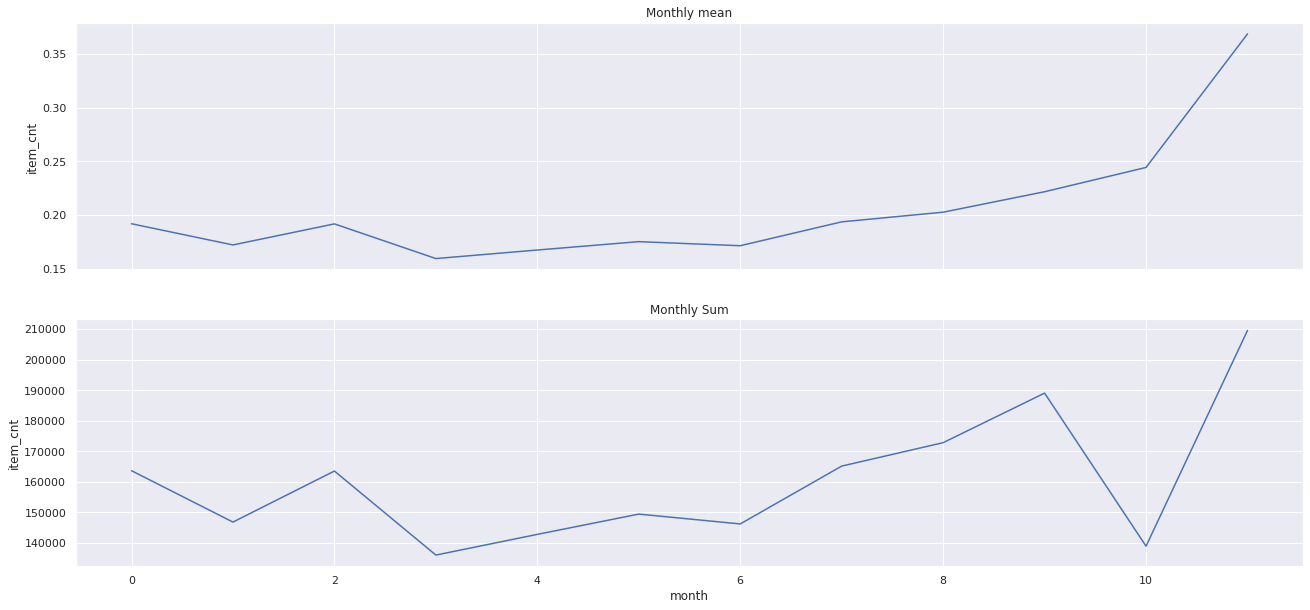

In [44]:
f, axes = plt.subplots(2,1,figsize=(22,10),sharex=True)

sns.lineplot(x='month',y='item_cnt',data=gp_month_mean,ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x='month',y='item_cnt',data=gp_month_sum,ax=axes[1]).set_title("Monthly Sum")
plt.show()

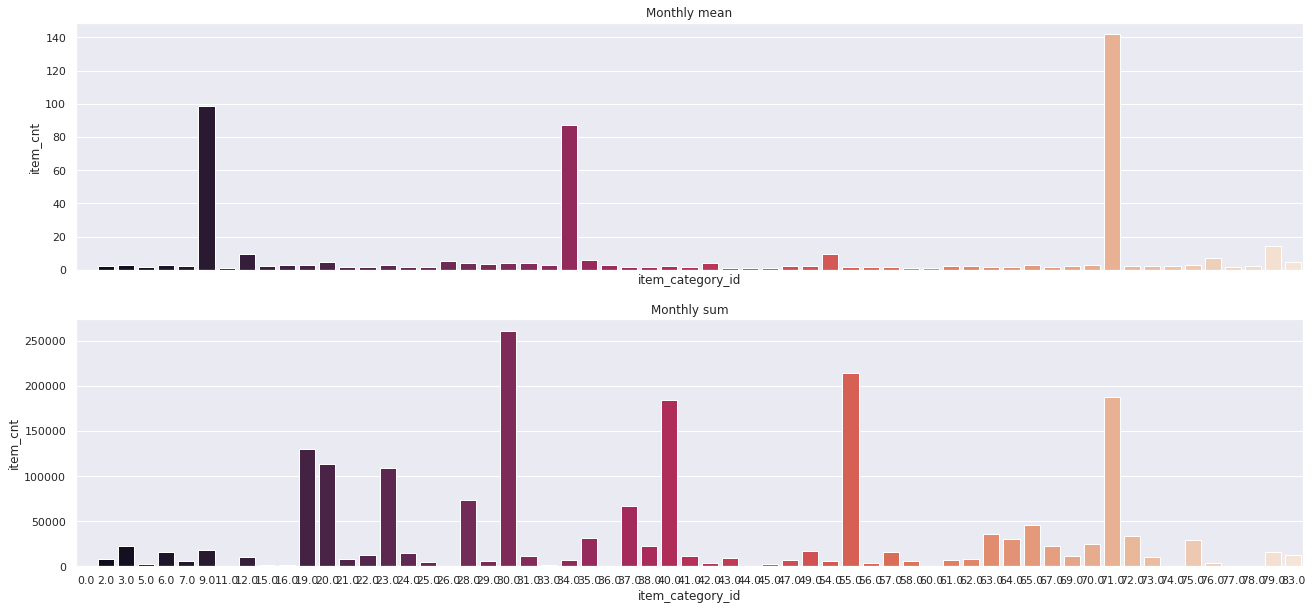

In [47]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_item_category_id_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_item_category_id_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

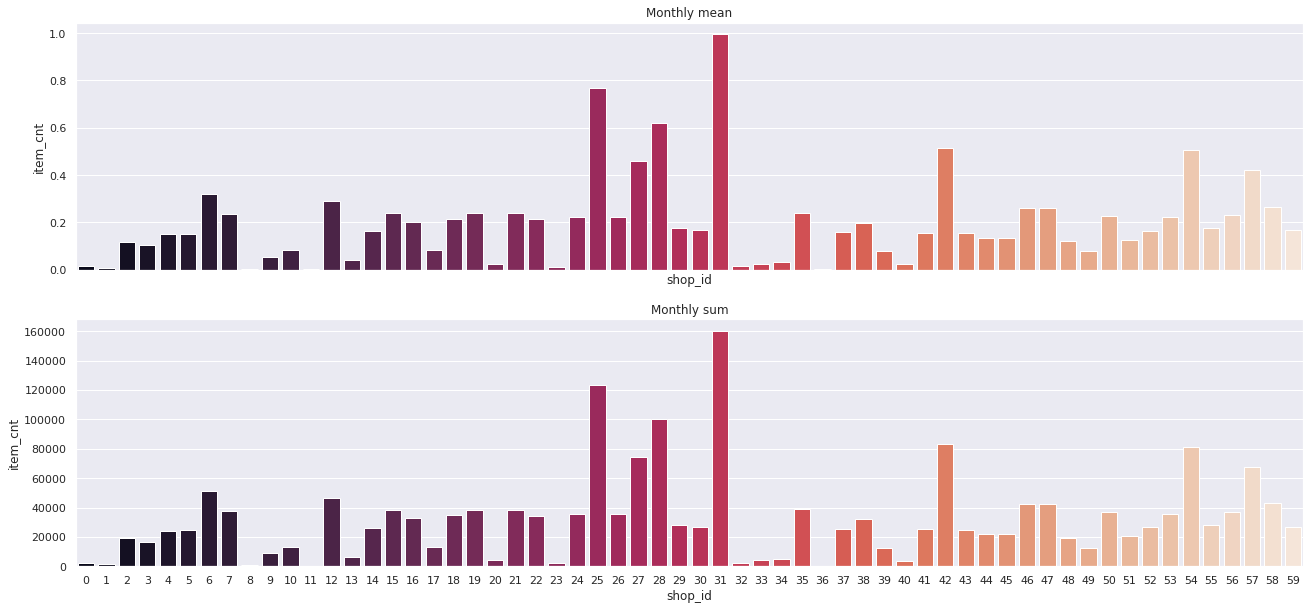

In [48]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_id_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_id_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

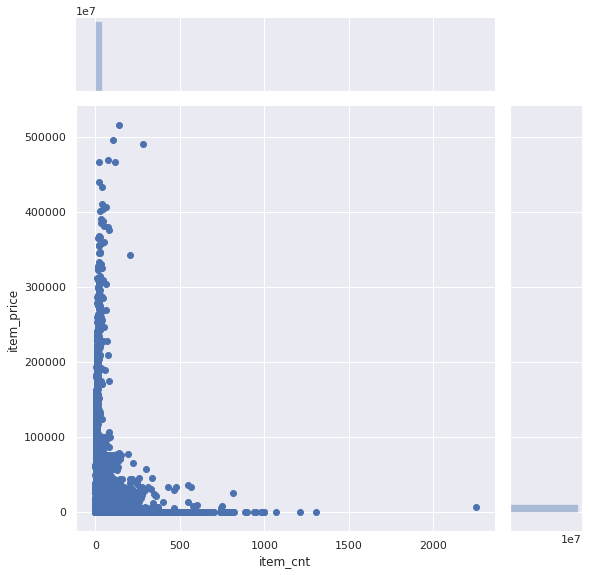

In [49]:
sns.jointplot(x='item_cnt',y='item_price',data=train_monthly,height=8)
plt.show()

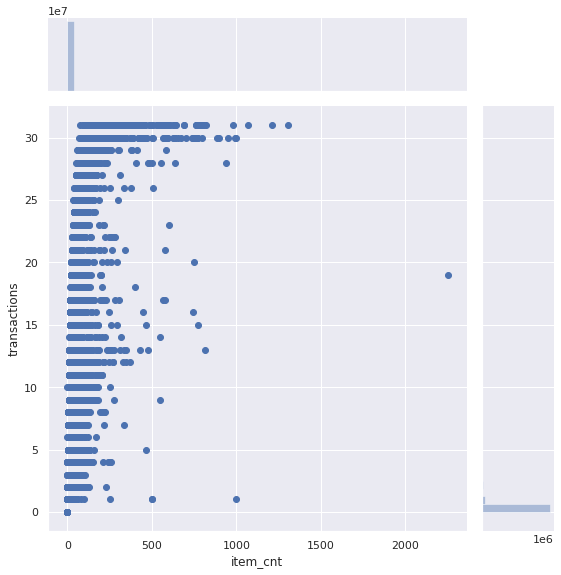

In [50]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

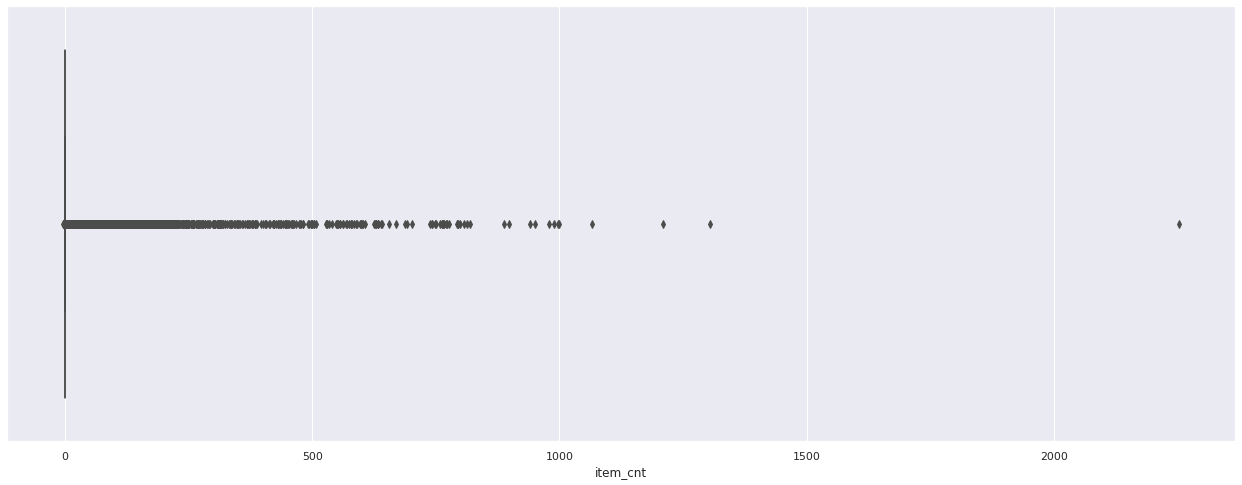

In [51]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()